＃ Model

送信データ →　変調器　→　拡散系列　→　伝送（雑音印加） →　拡散系列　→ 相関器 →　　復調器 →　受信データ

In [463]:
# import
import numpy as np
import sys

In [464]:
# データ生成器

def rndCode(codeSize, Type):
    """
    codeSize: 生成するランダム系列の大きさ（行数ｘ列数）を指定
    Type: タイプ指定 0: [0,1], 1: [-1, 1]
    """
    
    rndCode = np.random.randn(*codeSize)
    
    if rndCode.ndim > 2:
        sys.exit()
    
    dataSize = rndCode.shape
    if len(dataSize) == 1:
        sys.exit()
    
    if Type == 0:
        rndCode = np.where(rndCode <= 0, 0, 1)
    else:
        rndCode = np.where(rndCode <= 0, -1, 1)
    
    return rndCode

In [465]:
# BPSK変調器
def bpskMod(data):
    bpskSymbol = data.copy()
    np.place(bpskSymbol, bpskSymbol == 0, -1)
    
    return bpskSymbol

In [466]:
# 送信機

Ndata = 16 # データ数
SNRdB = 20 # 雑音比

Nchip = 100
Lss = Ndata * Nchip
Delay = np.array([[0,10]])
Npath = Delay.size

data = rndCode([Ndata, 1], 0)
bpskSymbol = bpskMod(data)

# 拡散系列
spCode = rndCode([Nchip, 1], 1)
ssSig = spCode * bpskSymbol.T
ssSig = np.array([ssSig.flatten()]).T

In [467]:
# ガウス雑音生成

def awgn(Pn, rn, cn):
    """
    Pn: 雑音電力
    ｒｎ: 行数
    cn: 列数
    """
    n = (np.random.randn(rn, cn)) + 1j * np.random.randn(rn, cn) * np.sqrt(Pn / 2)
    
    return n

In [468]:
# 遅延発生器
def delayGen(delayVec, sigMat):
    Nsig = delayVec.shape[1]
    
    if Nsig != sigMat.shape[1]:
        sys.exit(1)
    
    for co in range(0, Nsig):
        roll_num = delayVec[0][co]
        if delayVec[0][co] > 0:
            sigMat[:,co] = np.roll(sigMat[:,co],roll_num)
            sigMat[:roll_num, co] = 0
            
    return sigMat

In [469]:
# 選択性フェージング

## 遅延追加
ssSigMat = ssSig * np.ones((1,Npath))
ssSigMatDelayed = delayGen(Delay, ssSigMat)

chOut = np.array([ssSigMatDelayed.sum(axis=1)]).T

# 雑音印加
Pn = 10**(-SNRdB/10) * Nchip
rSig = chOut + awgn(Pn, Lss, 1)

In [470]:
rSig.shape

(1600, 1)

In [547]:
# 相関器
def correlator(w, sig):
    """
    w: 重み係数
    sig:　入力信号
    """
    
    sizeW = w.shape
    Lw = sizeW[0] # 1
    Nw = sizeW[1] # 100
    
    corIn = np.vstack([sig, np.zeros((100,1))])
    corOut = np.zeros((len(sig), Nw))
    
    for co in range(0, len(corOut)):
        corOut[co, :] = (w.conjugate() * corIn[co:(co + Lw)]).sum()

    return corOut

In [548]:
corOut = correlator(spCode, rSig)

<ipython-input-547-6852fb4768d4>:16: ComplexWarning: Casting complex values to real discards the imaginary part
  corOut[co, :] = (w.conjugate() * corIn[co:(co + Lw)]).sum()


<StemContainer object of 3 artists>

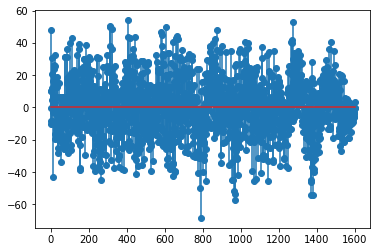

In [587]:
import matplotlib.pyplot as plt

plt.stem(corOut.real)

In [568]:
# BPSK復調器
def bpskDem(rSig):
    """
    rSig : 受信信号
    rData:　受信データ
    """
    rData = np.where(rSig < 0, 0, 1)
    
    return rData

In [588]:
corOut_rshp[1,:]

array([ 23.69014173,  26.56437619,   4.47373229,   4.67398866,
        18.74366175, -19.49960409, -16.29395206,   3.56503852,
        15.14083998,  32.32894503,  25.80872156, -13.83279202,
       -11.80115915, -19.01539882,  -4.06501702,  -9.70804387])

In [573]:
# 受信機
corOut_rshp = corOut.reshape(Nchip, Ndata)
rData = np.array([bpskDem(corOut_rshp[1,:])])

<StemContainer object of 3 artists>

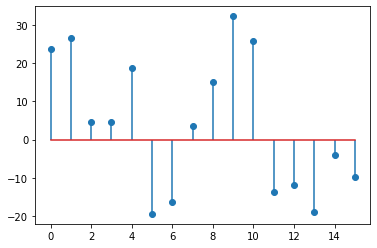

In [586]:
plt.stem(corOut_rshp[1,:])

In [580]:
data.T

array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0]])

In [581]:
rData

array([[1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0]])

In [577]:
# BER比較器
def ber(data1, data2):
    BER = np.sum(np.abs(data1-data2))/data1.size
    return BER

In [579]:
# ビットエラーレート（BER）の測定
ber(data, rData.T)

0.5